In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
from pathlib import Path

from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, explained_variance_score, accuracy_score
import pandas as pd

In [5]:
from skmixed.lme.problems import LinearLMEProblem
from skmixed.lme.oracles import LinearLMEOracle
from skmixed.lme.models import LinearLMESparseModel
from skmixed.lme.trees import Tree, Forest

## Choosing information criterion

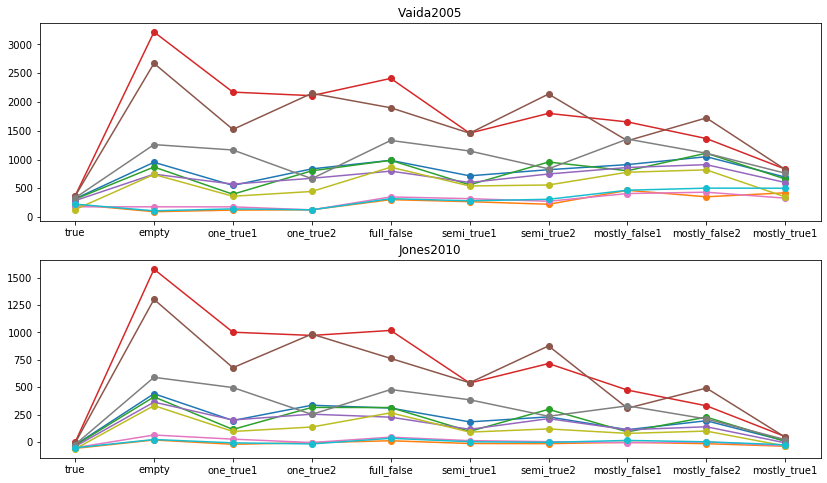

In [215]:
fig = plt.figure(figsize(14, 8))
grid = plt.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax1.set_title("Vaida2005")
ax2.set_title("Jones2010")

for seed in tqdm(range(10)):

    problem, true_parameters = LinearLMEProblem.generate(groups_sizes=[40, 30, 50],
                                                        features_labels=[3, 3, 6, 5, 5, 6],
                                                        random_intercept=True,
                                                        obs_std=0.1,
                                                        seed=seed)
    true_beta = true_parameters['beta']
    true_gamma = true_parameters['gamma']

    correctly_pivoted_problem = problem.pivot((0, 2, 3))
    correct_oracle = LinearLMEOracle(correctly_pivoted_problem)
    jones2010bic_ref = correct_oracle.jones2010bic(true_beta, true_gamma)
    vaida2005aic_ref = correct_oracle.vaida2005aic(true_beta, true_gamma)

    features_idxs = {
        "true": (0, 2, 3),
        "empty": (0, ),
        "one_true1": (0, 2), 
        "one_true2": (0, 3), 
        "full_false": (0, 1, 4),
        "semi_true1": (0, 1, 2),
        "semi_true2": (0, 3, 4),
        "mostly_false1": (0, 1, 2, 4),
        "mostly_false2": (0, 1, 3, 4),
        "mostly_true1": (0, 2, 3, 4),
    }


    vaida2005aics = []
    jones2010bics = []
    labels = []
    for label, categorical_feature_idx in features_idxs.items():
        pivoted_problem = problem.pivot(categorical_feature_idx)
        X, y = pivoted_problem.to_x_y()
        model = LinearLMESparseModel(lb=0, lg=0, initializer="EM") # no regularization 
        model.fit(X, y)
        pred_beta = model.coef_['beta']
        pred_gamma = model.coef_['gamma']
        oracle = LinearLMEOracle(pivoted_problem)
        vaida2005aics.append(oracle.vaida2005aic(pred_beta, pred_gamma))
        jones2010bics.append(oracle.jones2010bic(pred_beta, pred_gamma))
        labels.append(label)
        
    ax1.plot(labels, vaida2005aics, '-o')
    ax2.plot(labels, jones2010bics, '-o')
plt.show()

## Comparing one categorical tree to an indicator fit

In [6]:
mses_tree = []
mses_indicators = []
for j in tqdm(range(50)):
    problem_categorical, true_parameters = LinearLMEProblem.generate(groups_sizes=[40, 30, 50],
                                                                     features_labels=[3, 6, 5, 5, 6],
                                                                     random_intercept=True,
                                                                     obs_std=0.1,
                                                                     seed=j)

    continuous_model = LinearLMESparseModel(lb=0, lg=0, nnz_tbeta=2, nnz_tgamma=2)
    tree_model = Tree(model=continuous_model, max_depth=3)
    tree_model.fit_problem(problem_categorical)
    y_pred_tree = tree_model.predict_problem(problem_categorical)
    x, y_true = problem_categorical.to_x_y()

    column_labels_continuous = [3 if label==5 else label for label in problem_categorical.column_labels][1:]
    problem_indicators = problem_categorical.reconfigure_columns(new_columns_labels=column_labels_continuous)
    continuous_model.fit_problem(problem_indicators)
    y_pred_indicators = continuous_model.predict_problem(problem_indicators)

    explained_variance_tree = explained_variance_score(y_true, y_pred_tree)
    mse_tree = mean_squared_error(y_true, y_pred_tree)

    explained_variance_indicators = explained_variance_score(y_true, y_pred_indicators)
    mse_indicators = mean_squared_error(y_true, y_pred_indicators)
    mses_tree.append(mse_tree)
    mses_indicators.append(mse_indicators)

(0, 6)

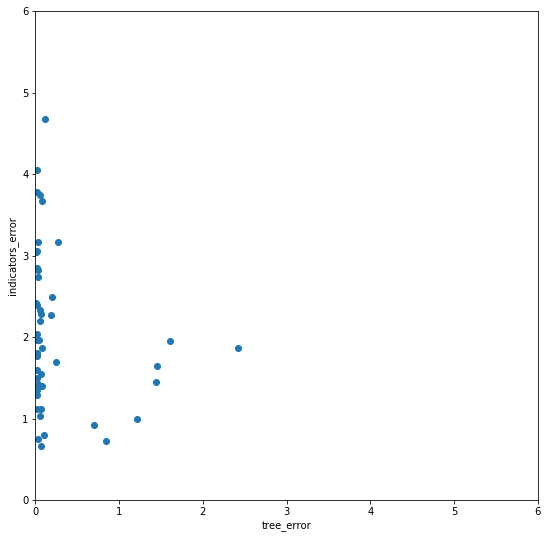

In [9]:
plt.figure(figsize=(9,9))
plt.scatter(mses_tree, mses_indicators)
plt.xlabel("tree_error")
plt.ylabel("indicators_error")
plt.xlim((0, 6))
plt.ylim((0, 6))

In [10]:
true_parameters['beta']

array([0.30096446, 0.24706183])

In [11]:
continuous_model.coef_['beta']

array([0.27158828, 0.06598069, 0.26470768, 0.37305017, 0.23185915,
       0.1536774 , 0.11601876])

In [12]:
tree_model.fitted_model_.coef_['beta']

array([0.54979194, 0.28580567])

## Evidence score data

In [168]:
!ls /Users/aksh/Storage/repos/skmixed/datasets/evidence_score_data/

calcium_colorectal.csv        pufa_ihd.csv
cheese_diabetes.csv           pufa_ihd_satfat.csv
dairy_cvd.csv                 redmeat_allcausemortality.csv
dairy_diabetes.csv            redmeat_breast.csv
dairy_ihd.csv                 redmeat_breast_post.csv
dairy_stroke.csv              redmeat_breast_pre.csv
fiber_colorectal.csv          redmeat_colorectal.csv
fiber_cvd.csv                 redmeat_diabetes.csv
fiber_diabetes.csv            redmeat_hemstroke.csv
fiber_ihd.csv                 redmeat_ihd.csv
fiber_stroke.csv              redmeat_ischstroke.csv
fish_ihd.csv                  redmeat_stroke.csv
fruit_diabetes.csv            sodium_cvd.csv
fruit_hemstroke.csv           sodium_stomach.csv
fruit_ihd.csv                 ssb_diabetes.csv
fruit_ischstroke.csv          ssb_ihd.csv
fruit_larynx.csv              sugar_cvd.csv
fruit_lungcancer.csv          sugar_diabetes.csv
fruit_nasopharynx.csv         sugar_obesity.csv
fruit_oesophageal.csv         transfat_ihd.csv
fruit_oral.csv  

In [179]:
dataset_path = Path("/Users/aksh/Storage/repos/skmixed/datasets/evidence_score_data/redmeat_allcausemortality.csv")

In [180]:
data = pd.read_csv(dataset_path)
data["linear_exposure"] = (data["b_0"] + data["b_1"])/2 - (data["a_0"] + data["a_1"])/2
data["se"] = np.exp(data["ln_se"])

In [181]:
data.columns

Index(['underlying_nid', 'nid', 'field_citation_value', 'b_0', 'b_1', 'a_0',
       'a_1', 'washout_years', 'ln_effect', 'ln_se', 'seq', 'total_red',
       'cohort', 'beef', 'pork', 'odds_ratio', 'nonstandard_exp', 'incidence',
       'mortality', 'follow_up', 'location', 'representative', 'exposure_1',
       'exposure_2', 'exposure_3', 'outcome_1', 'outcome_2', 'confounder_1',
       'confounder_2', 'reverse_causation', 'selection_bias',
       'linear_exposure', 'se'],
      dtype='object')

In [205]:
main_features_columns = ["nid", "linear_exposure", "ln_se"]

target_column = ["ln_effect"]

empty_columns = ["exposure_1",
                 'exposure_2', 
                 'outcome_1', 
                 'outcome_2', 
                 'confounder_1', 
                 'beef',
                 'pork',
                 'nonstandard_exp',
                 'selection_bias',
                 'reverse_causation'
                ]

maybe_continuous_features = [
    "seq",
    'follow_up',
]

categorical_features_columns = [
#    'sensitivity',
#    'representative',
    'total_red',
    "confounder_2",
    "exposure_3",
#    'odds_ratio',
#    'mortality',
]

In [197]:
data_short = data[main_features_columns + target_column + categorical_features_columns]
#groups_to_take = [121965, 412705, 396212]
#data_short = data_short[data_short["nid"].isin(groups_to_take)]

401039: 8
407856: 39
401046: 8
401050: 5
407858: 8
162637: 2
412555: 4
412557: 4
412561: 3
412568: 4
395783: 4


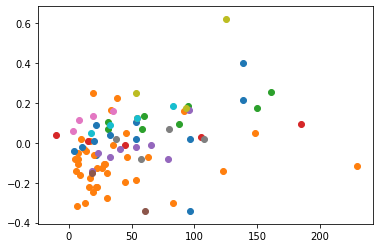

In [198]:
for nid in data_short["nid"].unique():
    group_data = data_short[data_short["nid"] == nid]
    plt.scatter(group_data["linear_exposure"], group_data["ln_effect"])
    print(f"{nid}: {len(group_data)}")
plt.show()

In [199]:
X.shape

(90, 9)

In [200]:
data_short[categorical_features_columns].describe()

,representative,total_red,confounder_2,exposure_3
count,89.0,89.000000,89.000000,89.000000
mean,1.0,0.483146,0.865169,0.876404
std,0.0,0.502547,0.343479,0.330984
min,1.0,0.000000,0.000000,0.000000
25%,1.0,0.000000,1.000000,1.000000
50%,1.0,0.000000,1.000000,1.000000
75%,1.0,1.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000


In [210]:
X = data_short[main_features_columns + categorical_features_columns].to_numpy()
y = data_short[target_column].to_numpy().flatten()
column_labels = [0, 3, 4] + [5]*len(categorical_features_columns)
X = np.vstack([column_labels, X])

In [211]:
problem = LinearLMEProblem.from_x_y(X, y)

In [212]:
for i, feature in enumerate(categorical_features_columns):
    print(f"{i+1}: {feature}")

1: total_red
2: confounder_2
3: exposure_3


In [213]:
oracle = LinearLMEOracle(problem)

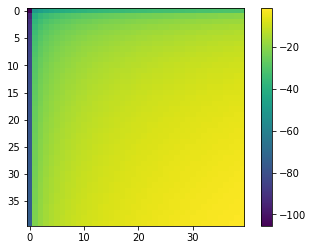

In [214]:
def plot_level_surfaces(oracle, xlims, ylims, ndots=1600):
    n = int(np.sqrt(ndots))
    xaxis = np.linspace(xlims[0], xlims[1], n)
    yaxis = np.linspace(ylims[0], ylims[1], n)
    result = np.zeros((n, n))
    for i, a in enumerate(xaxis):
        for j, b in enumerate(yaxis):
            gamma = np.array([a, b])
            beta = oracle.optimal_beta(gamma)
            loss = oracle.loss(beta, gamma)
            result[i, j] = loss
    plt.imshow(result)
    plt.colorbar()
plot_level_surfaces(oracle, (0, 10), (0, 10))

In [204]:
model = LinearLMESparseModel(lb=0, lg=0, nnz_tbeta=2, nnz_tgamma=2)
model.fit_problem(problem)
y_pred = model.predict_problem(problem)
#coefs = model.coef_["per_group_coefficients"]

LinAlgError: Singular matrix

In [195]:
X_without_labels = X[1:, :]

coefficients = model.coef_

plt.figure(figsize=(9, 6))
groups_to_plot = groups_to_take
colors = ['r', 'g', 'b']
for label, c in zip(groups_to_plot, colors):
    idx_of_this_label_in_train = np.where(coefficients["group_labels"] == label)[0]
    per_group_coefs = coefficients["per_group_coefficients"][idx_of_this_label_in_train][0]
    idxs = X_without_labels[:, 0] == label
    plt.scatter(X_without_labels[idxs][:, 1], y[idxs], c=c, label=label)
    plt.plot([0, 100], [per_group_coefs[0], per_group_coefs[0]+100*per_group_coefs[2]], c=c)
legend()

AttributeError: 'LinearLMESparseModel' object has no attribute 'coef_'